In [1]:
import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# some constants
PATCH_SIZE = 16  # pixels per side of square patches
VAL_SIZE = 10  # size of the validation set (number of images)
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

# unzip the dataset, split it and organize it in folders
if not os.path.isdir('validation'):  # make sure this has not been executed yet
  try:
          #!unzip cil-road-segmentation-2021.zip
          !mv training/training/* training
          !rm -rf training/training
          !mkdir validation
          !mkdir validation/images
          !mkdir validation/groundtruth
          for img in sample(glob("training/images/*.png"), VAL_SIZE):
            os.rename(img, img.replace('training', 'validation'))
            mask = img.replace('images', 'groundtruth')
            os.rename(mask, mask.replace('training', 'validation'))
  except:
      print('Please upload a .zip file containing your datasets.')

In [4]:
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.

# # paths to training and validation datasets
# train_path = '/content/drive/MyDrive/cil/training'
# val_path = '/content/drive/MyDrive/cil/validation'

# train_images = load_all_from_path(os.path.join(train_path, 'images'))
# train_masks = load_all_from_path(os.path.join(train_path, 'groundtruth'))
# val_images = load_all_from_path(os.path.join(val_path, 'images'))
# val_masks = load_all_from_path(os.path.join(val_path, 'groundtruth'))

In [5]:
def image_to_patches(images, masks=None):
    # takes in a 4D np.array containing images and (optionally) a 4D np.array containing the segmentation masks
    # returns a 4D np.array with an ordered sequence of patches extracted from the image and (optionally) a np.array containing labels
    n_images = images.shape[0]  # number of images
    h, w = images.shape[1:3]  # shape of images
    assert (h % PATCH_SIZE) + (w % PATCH_SIZE) == 0  # make sure images can be patched exactly

    h_patches = h // PATCH_SIZE
    w_patches = w // PATCH_SIZE
    patches = images.reshape((n_images, h_patches, PATCH_SIZE, h_patches, PATCH_SIZE, -1))
    patches = np.moveaxis(patches, 2, 3)
    patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    if masks is None:
        return patches

    masks = masks.reshape((n_images, h_patches, PATCH_SIZE, h_patches, PATCH_SIZE, -1))
    masks = np.moveaxis(masks, 2, 3)
    labels = np.mean(masks, (-1, -2, -3)) > CUTOFF  # compute labels
    labels = labels.reshape(-1).astype(np.float32)
    return patches, labels

# train_patches, train_labels = image_to_patches(train_images, train_masks)
# val_patches, val_labels = image_to_patches(val_images, val_masks)

In [6]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from torchvision import transforms

def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)

def accuracy_fn(y_hat, y):
    # computes classification accuracy
    return (y_hat.round() == y.round()).float().mean()

class ImageDataset(torch.utils.data.Dataset):
    # dataset class that deals with loading the data and making it available by index.

    def __init__(self, path, device, use_patches=True, resize_to=(400, 400)):
        self.path = path
        self.device = device
        self.use_patches = use_patches
        self.resize_to=resize_to
        self.x, self.y, self.n_samples = None, None, None
        self._load_data()
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        #self.transform = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    def _load_data(self):  # not very scalable, but good enough for now
        self.x = load_all_from_path(os.path.join(self.path, 'images'))
        self.y = load_all_from_path(os.path.join(self.path, 'groundtruth'))
        if self.use_patches:  # split each image into patches
            self.x, self.y = image_to_patches(self.x, self.y)
        elif self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        self.n_samples = len(self.x)

    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing
        # print("preprocess x, y shape", x.shape, y.shape)
        #x = self.transform(x)
        #print(x.shape, y.shape)
        return x, y

    def __getitem__(self, item):
        return self._preprocess(np_to_tensor(self.x[item], self.device), np_to_tensor(self.y[[item]], self.device))
    
    def __len__(self):
        return self.n_samples

In [7]:
def patch_accuracy_fn(y_hat, y):
    # computes accuracy weighted by patches (metric used on Kaggle for evaluation)
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    patches_hat = y_hat.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    patches = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return (patches == patches_hat).float().mean()

In [8]:
%cd /content/drive/MyDrive/cil/

/content/drive/MyDrive/cil


In [9]:
import torch
from torch import nn
import torch.nn.functional as F

import model.resnet as models

import importlib
importlib.reload(models)

class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)


class PSPNet(nn.Module):
    def __init__(self, layers=50, bins=(1, 2, 3, 6), dropout=0.1, classes=2, zoom_factor=8, use_ppm=True, criterion=nn.CrossEntropyLoss(ignore_index=-1), pretrained=True, train = False):
        super(PSPNet, self).__init__()
        assert layers in [50, 101, 152]
        assert 2048 % len(bins) == 0
        assert classes > 1
        assert zoom_factor in [1, 2, 4, 8]
        self.zoom_factor = zoom_factor
        self.use_ppm = use_ppm
        self.criterion = criterion
        self.training = train

        if layers == 50:
            resnet = models.resnet50(pretrained=pretrained)
        elif layers == 101:
            resnet = models.resnet101(pretrained=pretrained)
        else:
            resnet = models.resnet152(pretrained=pretrained)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.conv2, resnet.bn2, resnet.relu, resnet.conv3, resnet.bn3, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)

        fea_dim = 2048
        if use_ppm:
            self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)
            fea_dim *= 2
        self.cls = nn.Sequential(
            nn.Conv2d(fea_dim, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, classes, kernel_size=1)
        )
        #if self.training:
        self.aux = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(256, classes, kernel_size=1),
            #nn.Softmax(dim=1)
        )

    def forward(self, x, y=None):
        x_size = x.size()
        # assert (x_size[2]-1) % 8 == 0 and (x_size[3]-1) % 8 == 0
        h = int((x_size[2] - 1) / 8 * self.zoom_factor + 1)
        w = int((x_size[3] - 1) / 8 * self.zoom_factor + 1)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_tmp = self.layer3(x)
        x = self.layer4(x_tmp)
        if self.use_ppm:
            x = self.ppm(x)
        x = self.cls(x)
        #if self.zoom_factor != 1:
            # x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)
        x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=True)
        #print("pspnet x shape", x.shape)
        #print(x)
        
        if self.training:
            aux = self.aux(x_tmp)
            #if self.zoom_factor != 1:
            aux = F.interpolate(aux, scale_factor=8, mode='bilinear', align_corners=True)
            #print("pspnet aux shape", aux.shape)
            #print("x.max(1)[1]", x.max(1)[1].shape)
            #print(x.max(1)[1])
            #print(torch.sum(x.max(1)[1]))
            #print(aux)
            main_loss = self.criterion(x, y)
            aux_loss = self.criterion(aux, y)
            return x.max(1)[1], main_loss, aux_loss
        else:
            aux = self.aux(x_tmp)
            aux = F.interpolate(aux, scale_factor=8, mode='bilinear', align_corners=True)
            main_loss = self.criterion(x, y)
            aux_loss = self.criterion(aux, y)
            return x.max(1)[1], main_loss, aux_loss
            #return x

In [13]:
def train(train_dataloader, eval_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs):
    # training loop
    logdir = './tensorboard/pspnet'
    writer = SummaryWriter(logdir)  # tensorboard writer (can also log images)

    history = {}  # collects metrics at the end of each epoch

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        model.train()
        for (x, y) in pbar:
            optimizer.zero_grad()  # zero out gradients
            y = y.squeeze(1).long() #(8, 400, 400)
            #print("x, y shape", x.shape, y.shape)
            y_hat, main_loss, aux_loss = model(x, y)  # forward pass
            # loss = loss_fn(y_hat, y)
            #print(main_loss, aux_loss)
            loss = main_loss + 0.4 * aux_loss
            loss.backward()  # backward pass
            optimizer.step()  # optimize weights

            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(y_hat.float(), y.float()).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        model.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_squeeze = y.squeeze(1).long()
                y_hat, main_loss, aux_loss = model(x, y_squeeze)  # forward pass
                loss = main_loss + 0.4 * aux_loss
                # loss = loss_fn(y_hat, y)
                
                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat.float(), y.float()).item())

        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        y_hat = y_hat.unsqueeze(1)
        print(torch.sum(y_hat[0]), torch.sum(y[0]))
        show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())

    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [14]:
def show_val_samples(x, y, y_hat, segmentation=False):
    # training callback to show predictions on validation set
    imgs_to_draw = min(5, len(x))
    if x.shape[-2:] == y.shape[-2:]:  # segmentation
        fig, axs = plt.subplots(3, imgs_to_draw, figsize=(18.5, 12))
        for i in range(imgs_to_draw):
            axs[0, i].imshow(np.moveaxis(x[i], 0, -1))
            axs[1, i].imshow(np.concatenate([np.moveaxis(y_hat[i], 0, -1)] * 3, -1))
            axs[2, i].imshow(np.concatenate([np.moveaxis(y[i], 0, -1)]*3, -1))
            axs[0, i].set_title(f'Sample {i}')
            axs[1, i].set_title(f'Predicted {i}')
            axs[2, i].set_title(f'True {i}')
            axs[0, i].set_axis_off()
            axs[1, i].set_axis_off()
            axs[2, i].set_axis_off()
    else:  # classification
        fig, axs = plt.subplots(1, imgs_to_draw, figsize=(18.5, 6))
        for i in range(imgs_to_draw):
            axs[i].imshow(np.moveaxis(x[i], 0, -1))
            axs[i].set_title(f'True: {np.round(y[i]).item()}; Predicted: {np.round(y_hat[i]).item()}')
            axs[i].set_axis_off()
    plt.show()

Ignoring "Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv2.weight", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "conv3.weight", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var". 
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 3, 3, 3]).
	size mismatch for layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 128, 1, 1]).
	size mismatch for layer1.0.downsample.0.weight: copying a param with shape torch.Size([256, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1])."



	- loss = 0.7180081407229105
  	- val_loss = 0.8256136476993561
  	- acc = 0.8882984817028046
  	- val_acc = 0.8001080751419067
 
tensor(6364, device='cuda:0') tensor(16694.8789, device='cuda:0')


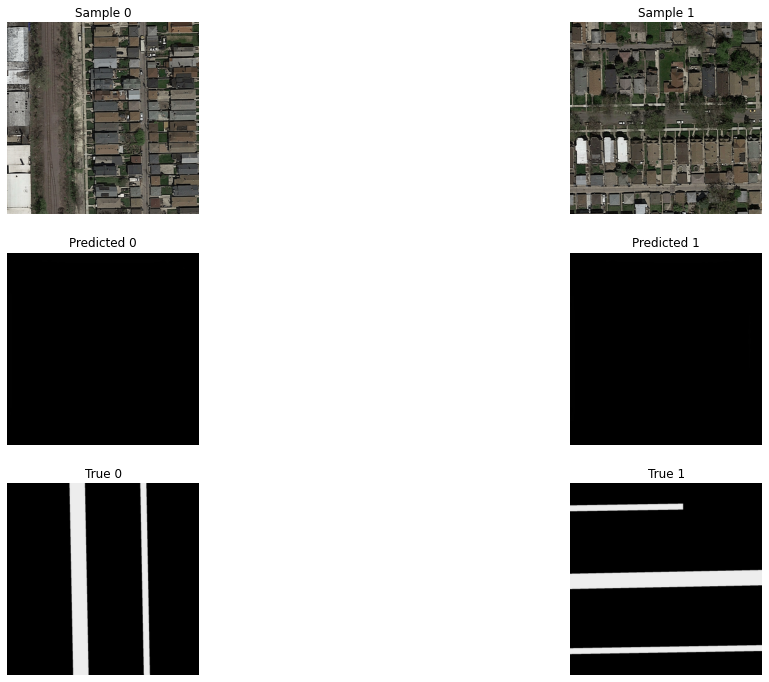


	- loss = 0.7047948191563288
  	- val_loss = 0.8958517014980316
  	- acc = 0.9129991233348846
  	- val_acc = 0.6441071033477783
 
tensor(21679, device='cuda:0') tensor(42676.2109, device='cuda:0')


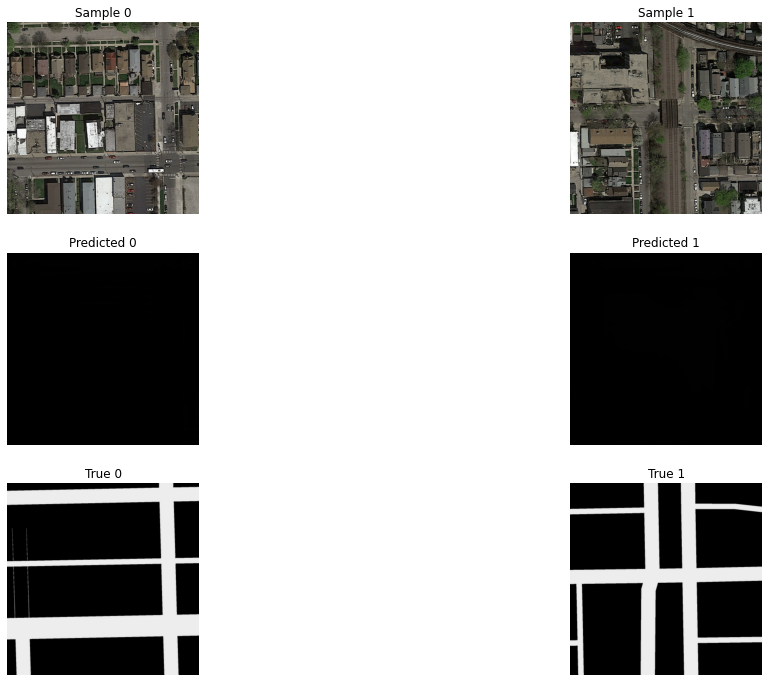


	- loss = 0.697505866487821
  	- val_loss = 0.6402695775032043
  	- acc = 0.91495414574941
  	- val_acc = 0.760356217622757
 
tensor(1942, device='cuda:0') tensor(39244.5117, device='cuda:0')


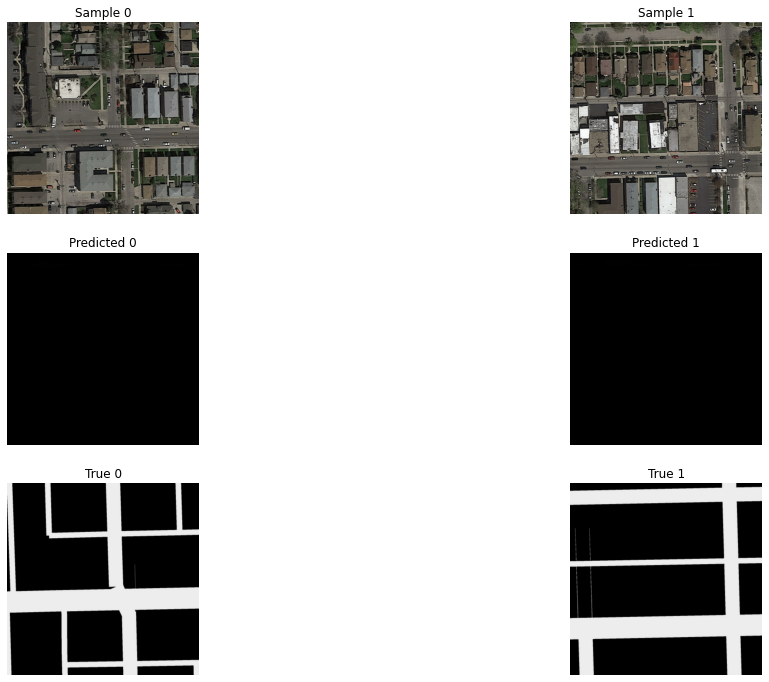


	- loss = 0.7317316482464472
  	- val_loss = 0.6130819320678711
  	- acc = 0.8750946372747421
  	- val_acc = 0.7900250554084778
 
tensor(455, device='cuda:0') tensor(27710.2285, device='cuda:0')


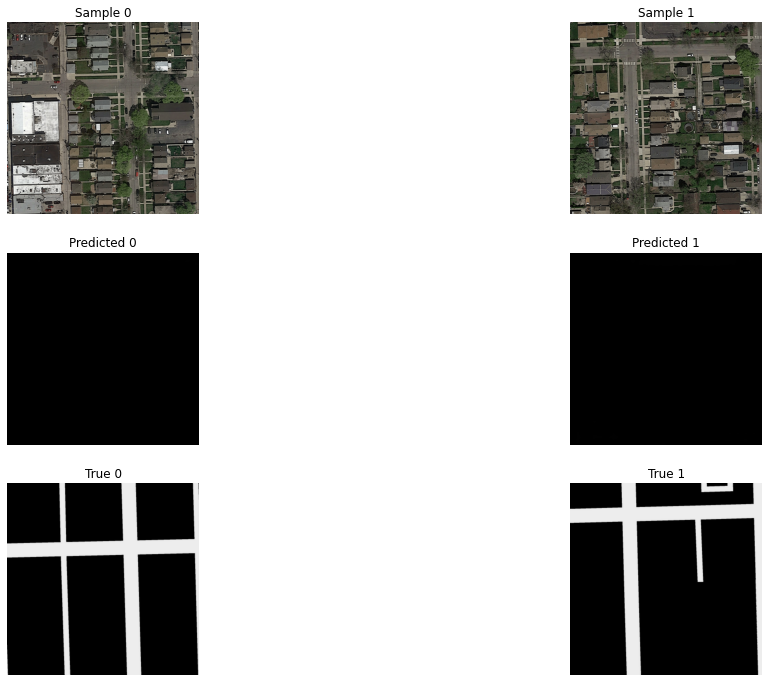


	- loss = 0.703421930472056
  	- val_loss = 0.6048663258552551
  	- acc = 0.9003368268410364
  	- val_acc = 0.8114383518695831
 
tensor(1767, device='cuda:0') tensor(27921.2031, device='cuda:0')


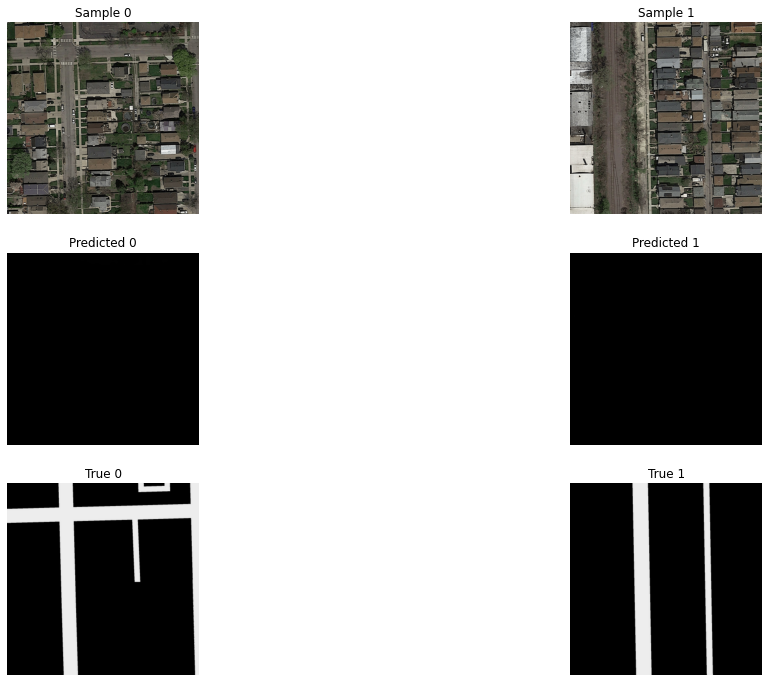


	- loss = 0.6882951011260351
  	- val_loss = 0.632543683052063
  	- acc = 0.9115437964598337
  	- val_acc = 0.7642182409763336
 
tensor(3035, device='cuda:0') tensor(42676.2109, device='cuda:0')


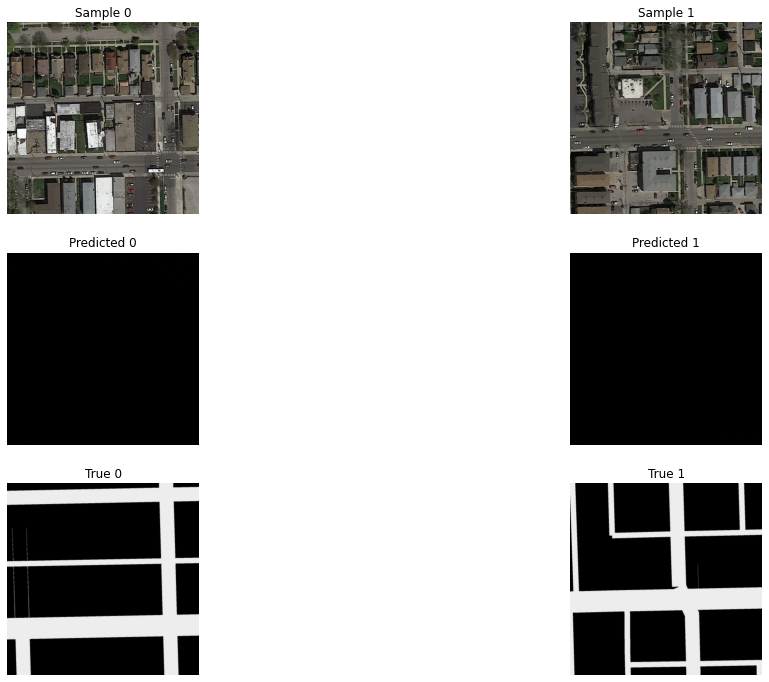


	- loss = 0.6687757670879364
  	- val_loss = 0.6363920569419861
  	- acc = 0.9172025173902512
  	- val_acc = 0.7722531855106354
 
tensor(1058, device='cuda:0') tensor(38237.3594, device='cuda:0')


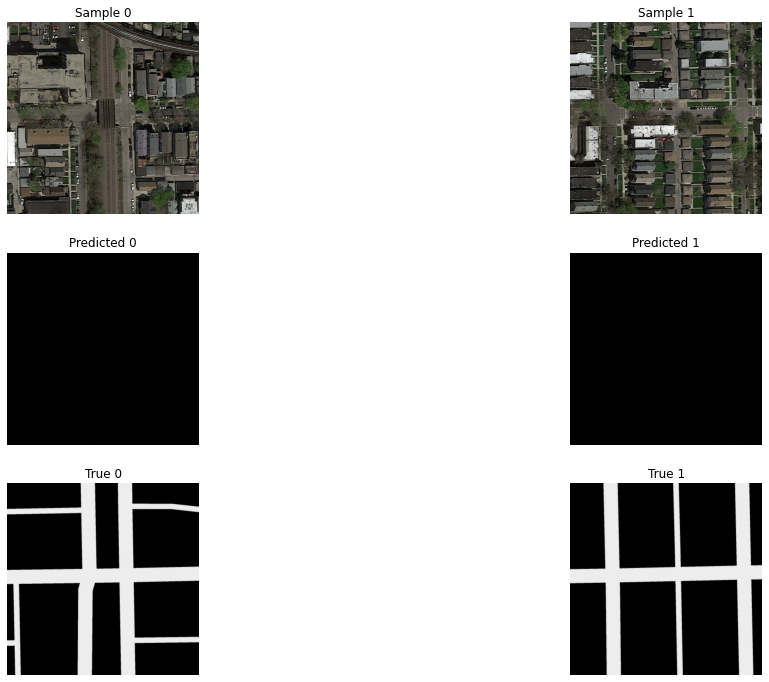


	- loss = 0.6836777577797571
  	- val_loss = 0.624921053647995
  	- acc = 0.9154722442229589
  	- val_acc = 0.7625378668308258
 
tensor(696, device='cuda:0') tensor(42676.2109, device='cuda:0')


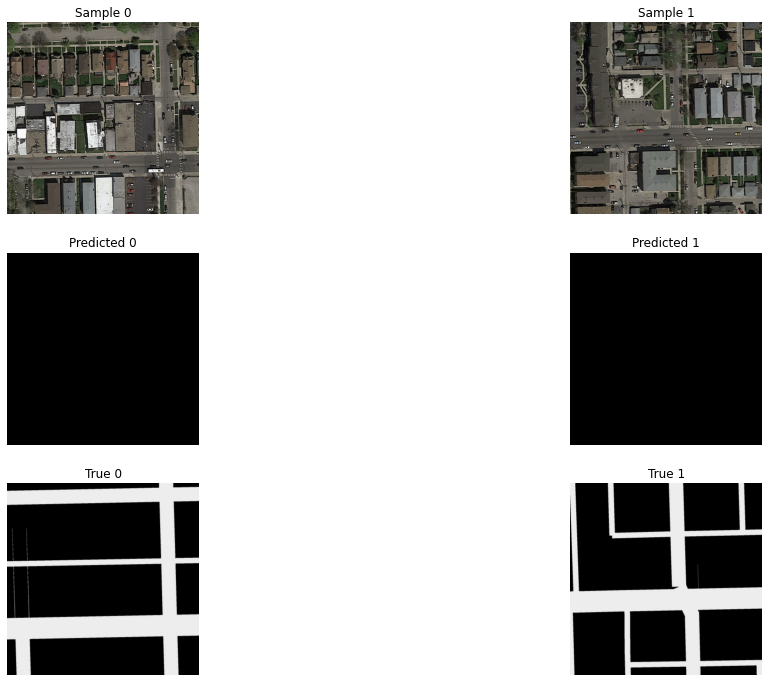


	- loss = 0.6775092979272207
  	- val_loss = 0.6312949955463409
  	- acc = 0.9268406629562378
  	- val_acc = 0.8059574961662292
 
tensor(3390, device='cuda:0') tensor(26694., device='cuda:0')


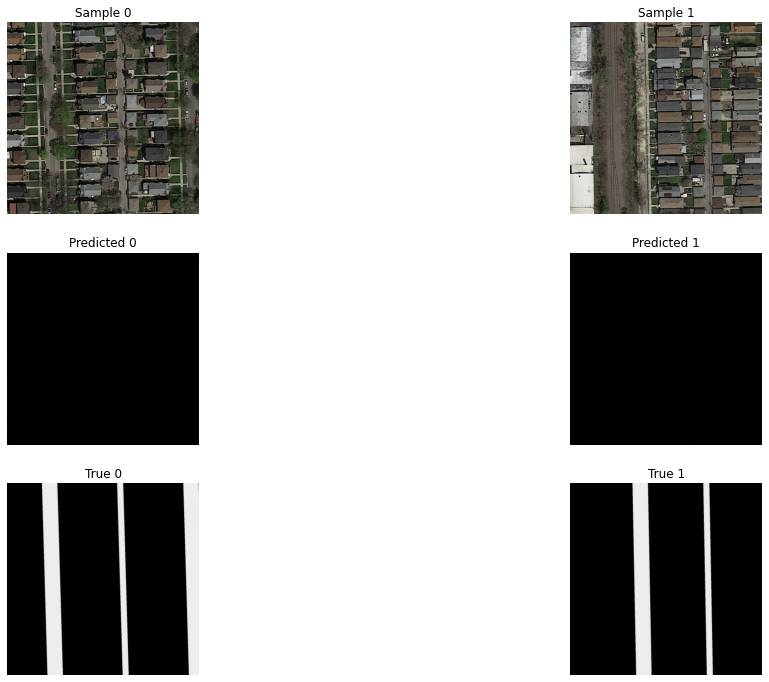


	- loss = 0.6797565172115961
  	- val_loss = 0.5933156311511993
  	- acc = 0.9253314932187399
  	- val_acc = 0.768844723701477
 
tensor(441, device='cuda:0') tensor(35274.7852, device='cuda:0')


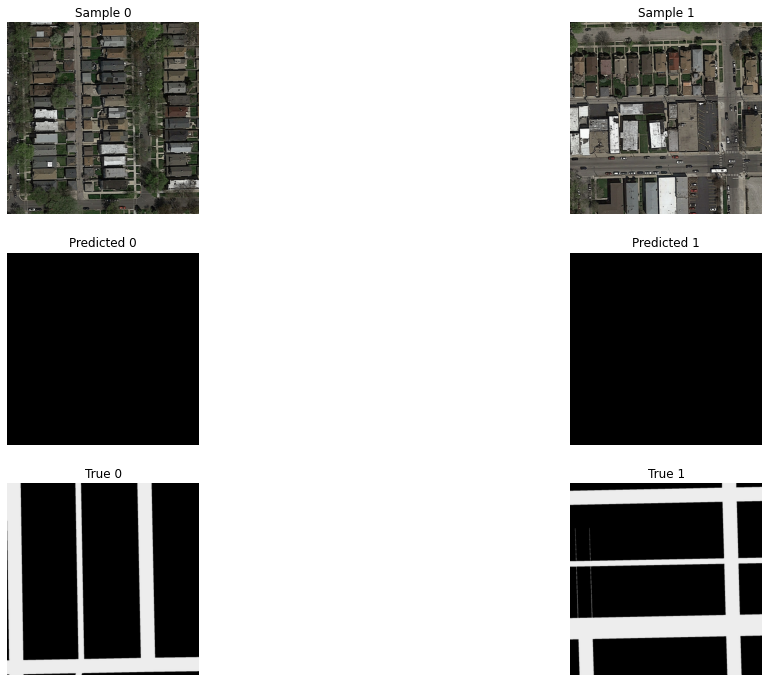


	- loss = 0.6620921244223913
  	- val_loss = 0.5844775140285492
  	- acc = 0.9404282967249552
  	- val_acc = 0.7838747799396515
 
tensor(808, device='cuda:0') tensor(27921.2031, device='cuda:0')


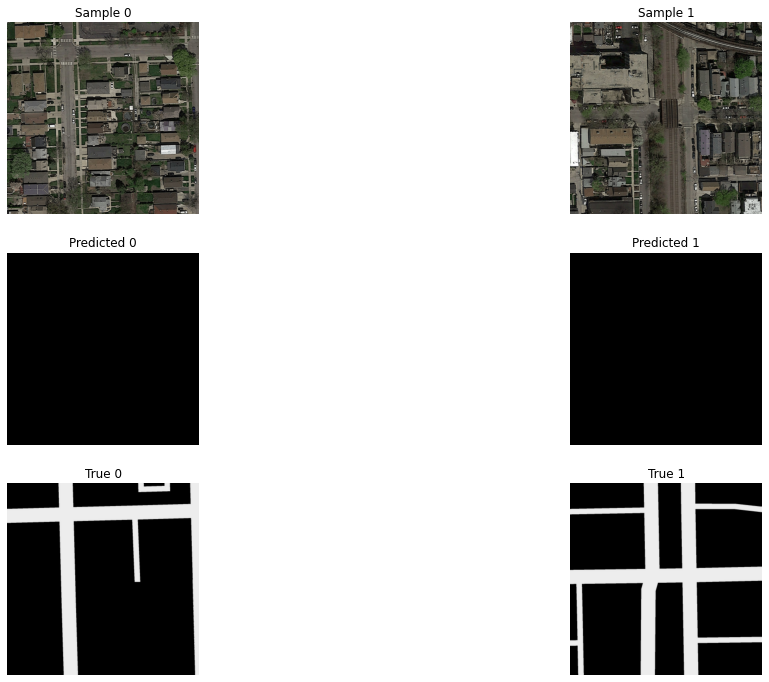


	- loss = 0.6594532877206802
  	- val_loss = 0.5954364240169525
  	- acc = 0.9249641050895056
  	- val_acc = 0.777118444442749
 
tensor(1098, device='cuda:0') tensor(27710.2285, device='cuda:0')


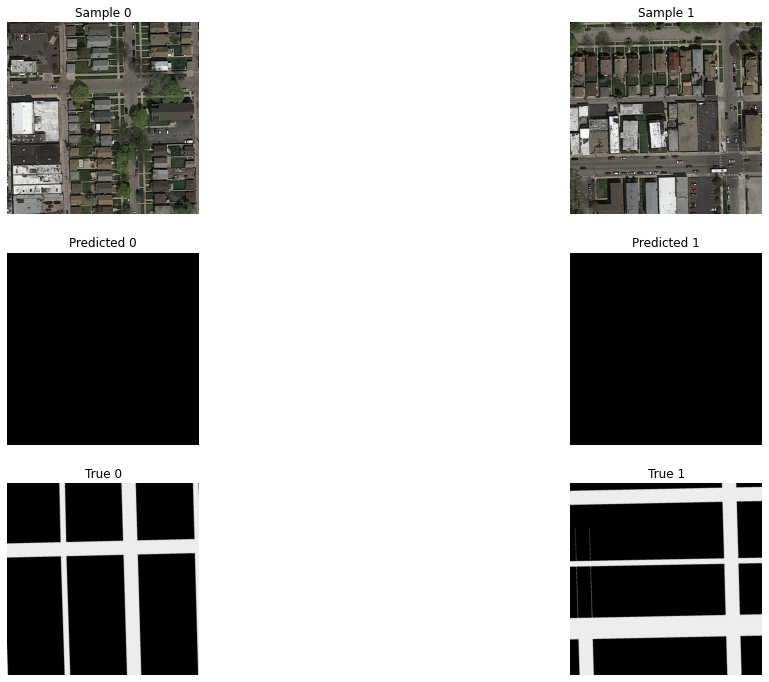


	- loss = 0.6998387028773626
  	- val_loss = 0.5895961225032806
  	- acc = 0.8851087689399719
  	- val_acc = 0.7735919952392578
 
tensor(1268, device='cuda:0') tensor(35444.9219, device='cuda:0')


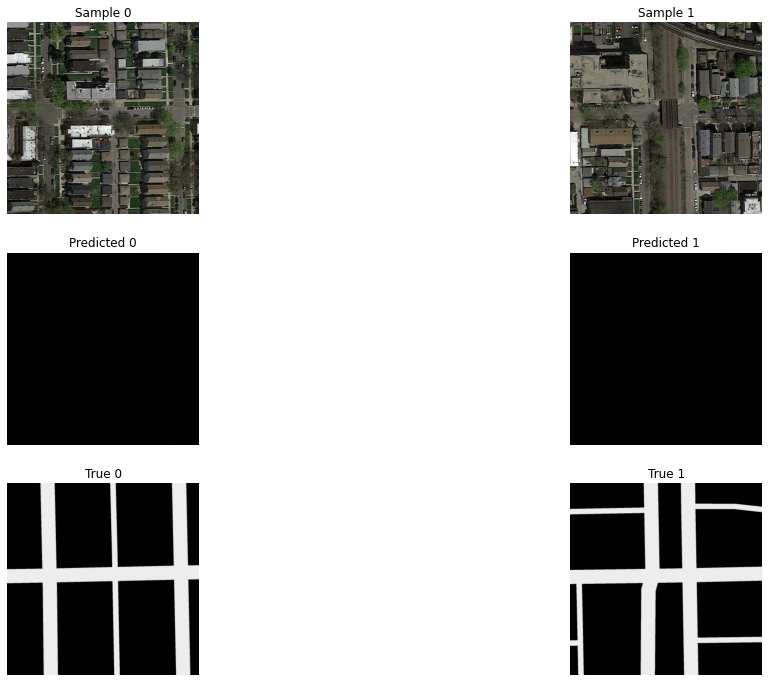


	- loss = 0.6872771829366684
  	- val_loss = 0.5826993882656097
  	- acc = 0.9129706174135208
  	- val_acc = 0.7678680419921875
 
tensor(968, device='cuda:0') tensor(42676.2109, device='cuda:0')


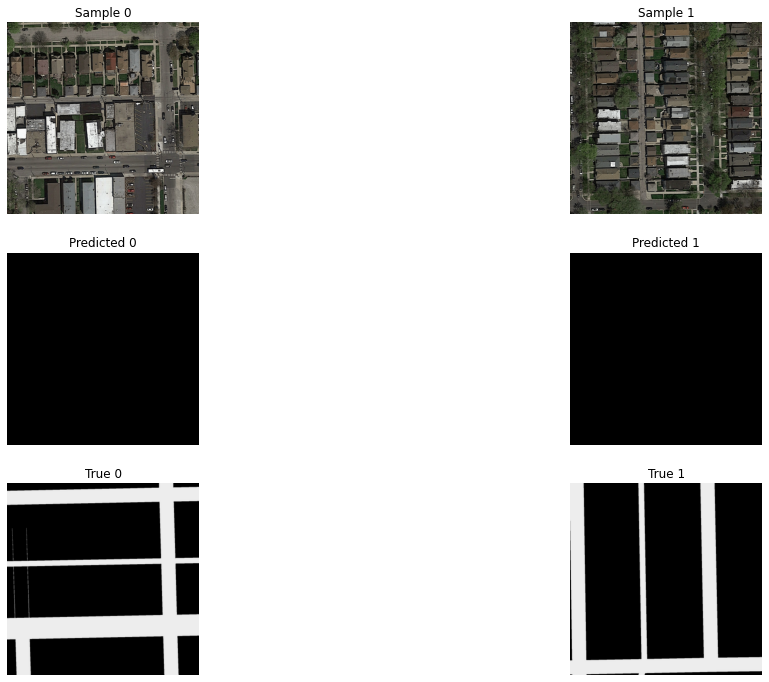


	- loss = 0.6646848420302073
  	- val_loss = 0.5929715037345886
  	- acc = 0.9234449019034704
  	- val_acc = 0.7886787950992584
 
tensor(2490, device='cuda:0') tensor(16694.8789, device='cuda:0')


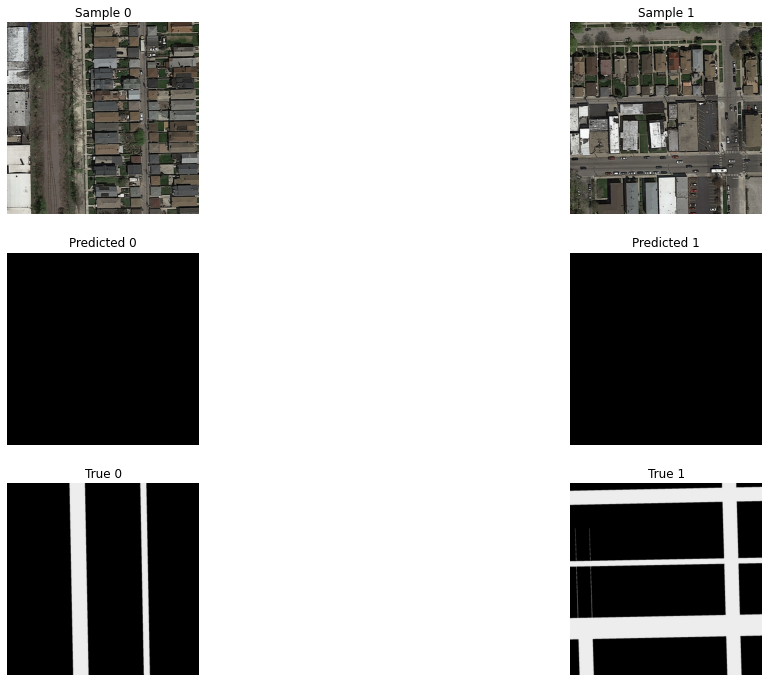


	- loss = 0.6489111185073853
  	- val_loss = 0.6085080504417419
  	- acc = 0.939106673002243
  	- val_acc = 0.7745067179203033
 
tensor(2635, device='cuda:0') tensor(35444.9219, device='cuda:0')


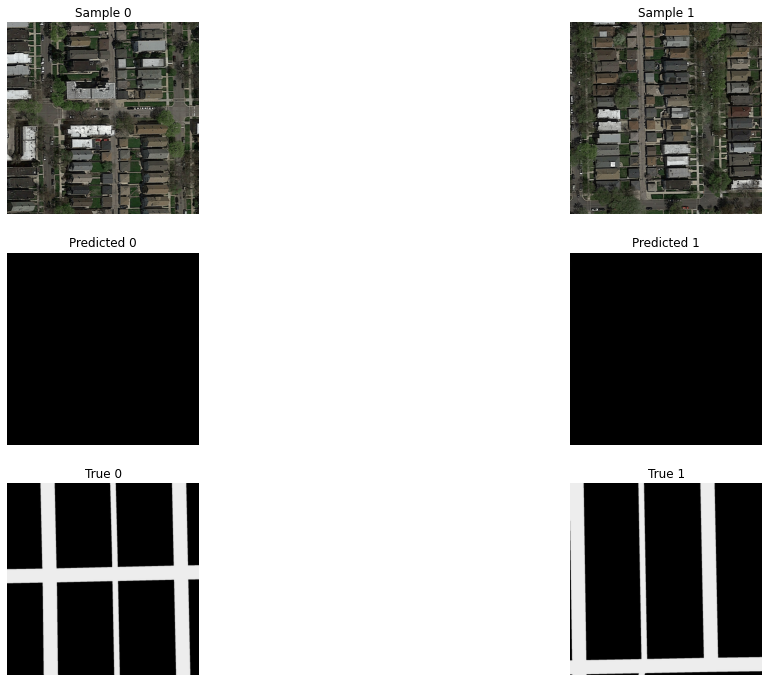


	- loss = 0.668824682633082
  	- val_loss = 0.6166248321533203
  	- acc = 0.9381699661413828
  	- val_acc = 0.8040283024311066
 
tensor(4015, device='cuda:0') tensor(26694., device='cuda:0')


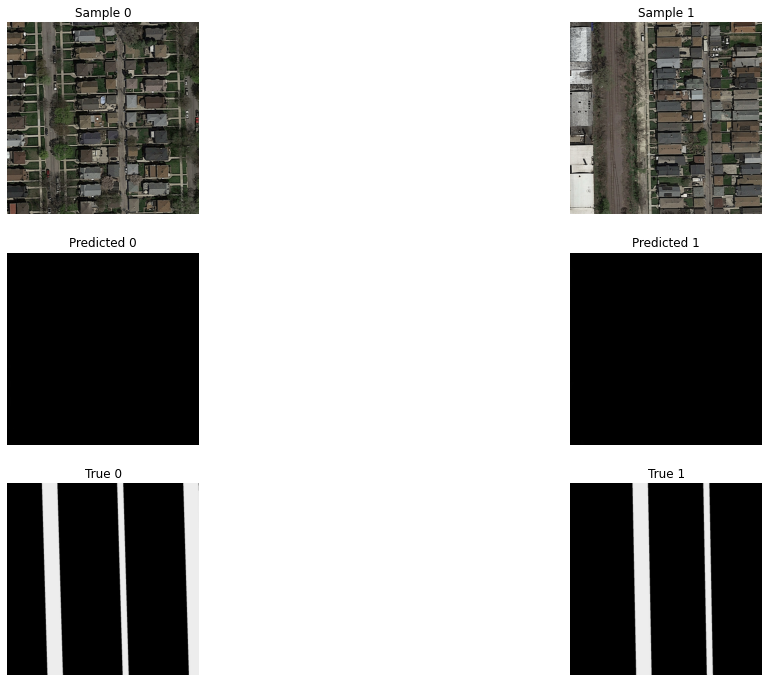


	- loss = 0.6469684292872747
  	- val_loss = 0.5976998209953308
  	- acc = 0.9378630667924881
  	- val_acc = 0.7975939214229584
 
tensor(2973, device='cuda:0') tensor(16694.8789, device='cuda:0')


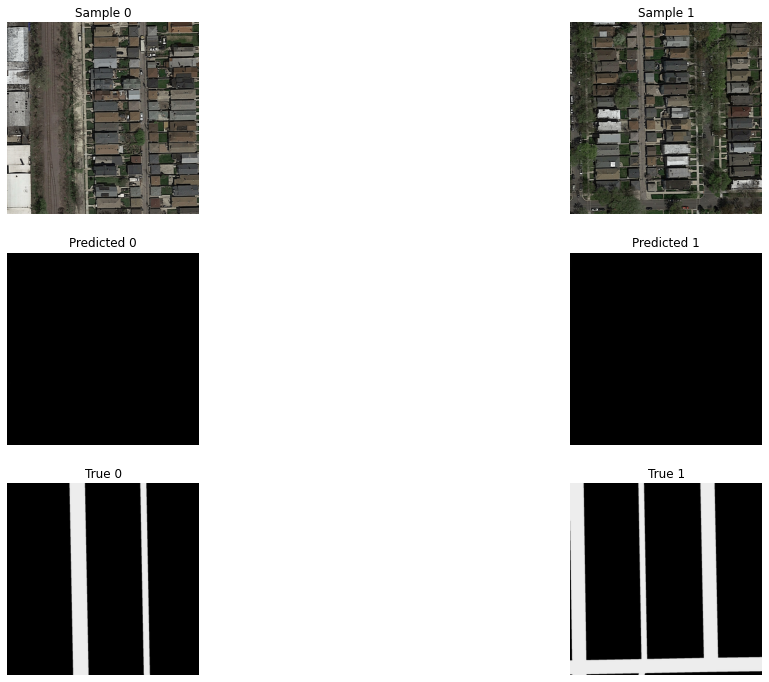


	- loss = 0.6196244110663732
  	- val_loss = 0.5849483013153076
  	- acc = 0.9504464616378149
  	- val_acc = 0.7715286910533905
 
tensor(1212, device='cuda:0') tensor(38237.3594, device='cuda:0')


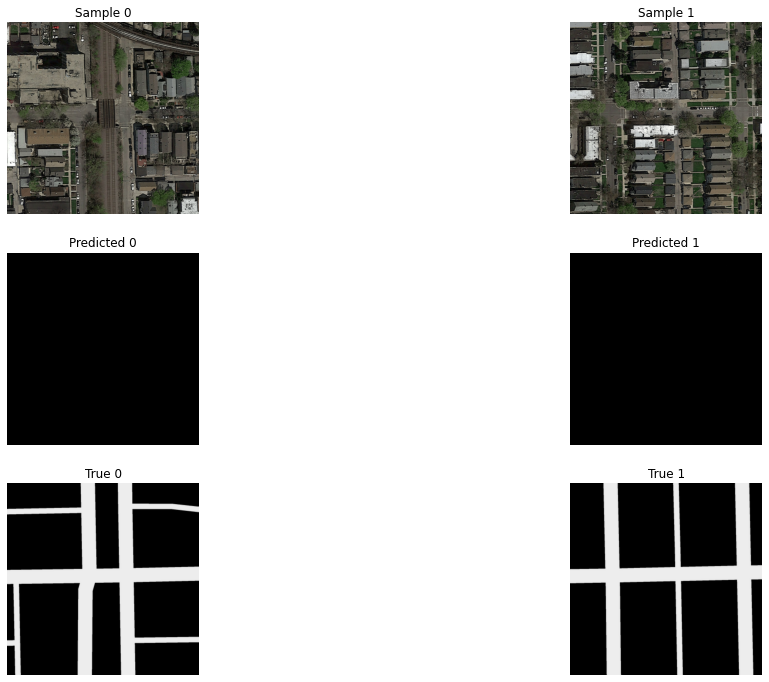


	- loss = 0.6320465604464213
  	- val_loss = 0.5602178275585175
  	- acc = 0.9354258924722672
  	- val_acc = 0.8072546720504761
 
tensor(676, device='cuda:0') tensor(27710.2285, device='cuda:0')


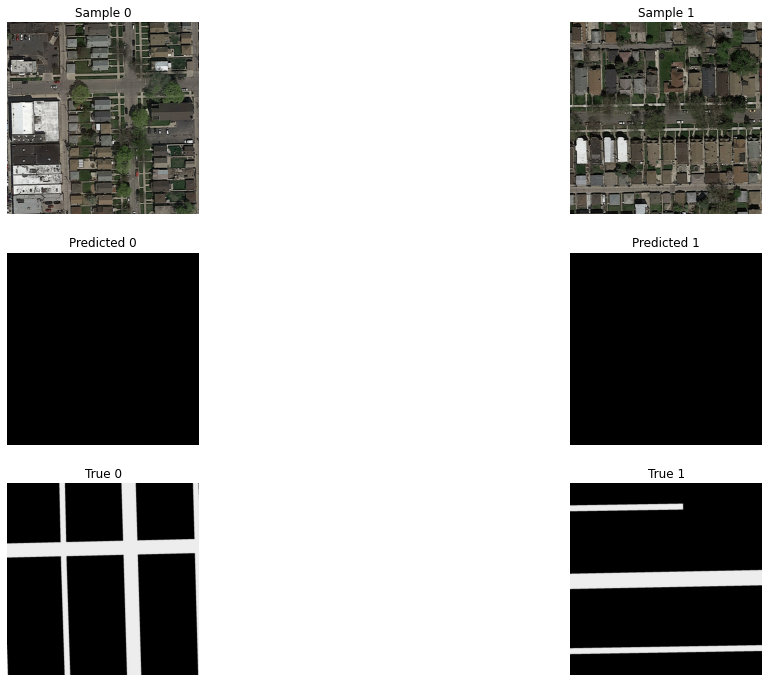


	- loss = 0.6353068302075068
  	- val_loss = 0.5870642960071564
  	- acc = 0.9417101939519247
  	- val_acc = 0.7967865765094757
 
tensor(1771, device='cuda:0') tensor(35444.9219, device='cuda:0')


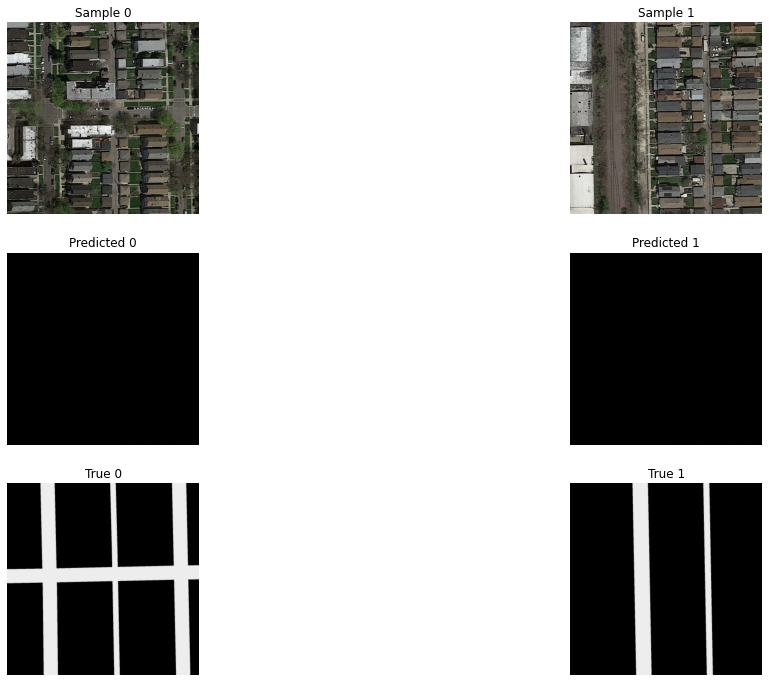


	- loss = 0.6109759906927744
  	- val_loss = 0.5615458190441132
  	- acc = 0.9472829103469849
  	- val_acc = 0.8180494904518127
 
tensor(2292, device='cuda:0') tensor(16694.8789, device='cuda:0')


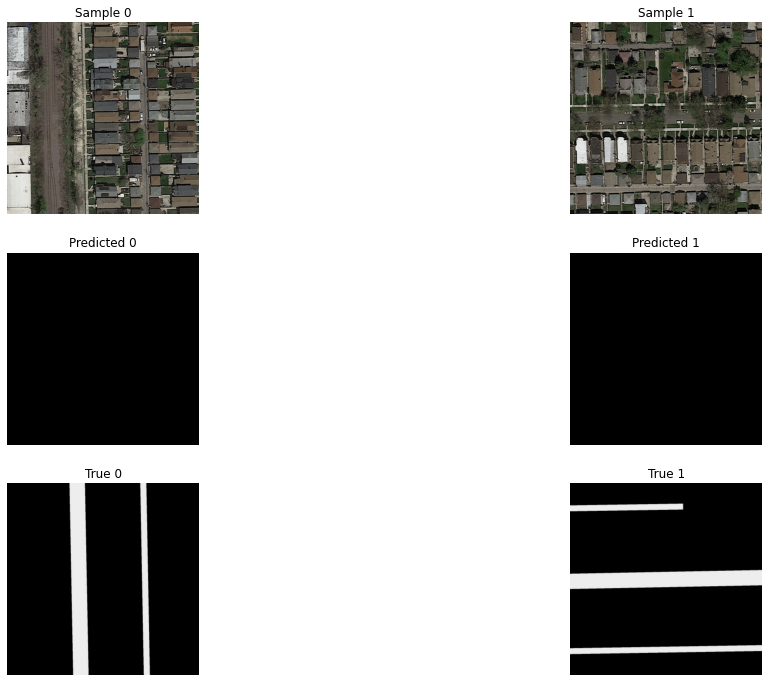


	- loss = 0.617476686835289
  	- val_loss = 0.5565763413906097
  	- acc = 0.9398544033368429
  	- val_acc = 0.7758762538433075
 
tensor(1121, device='cuda:0') tensor(42676.2109, device='cuda:0')


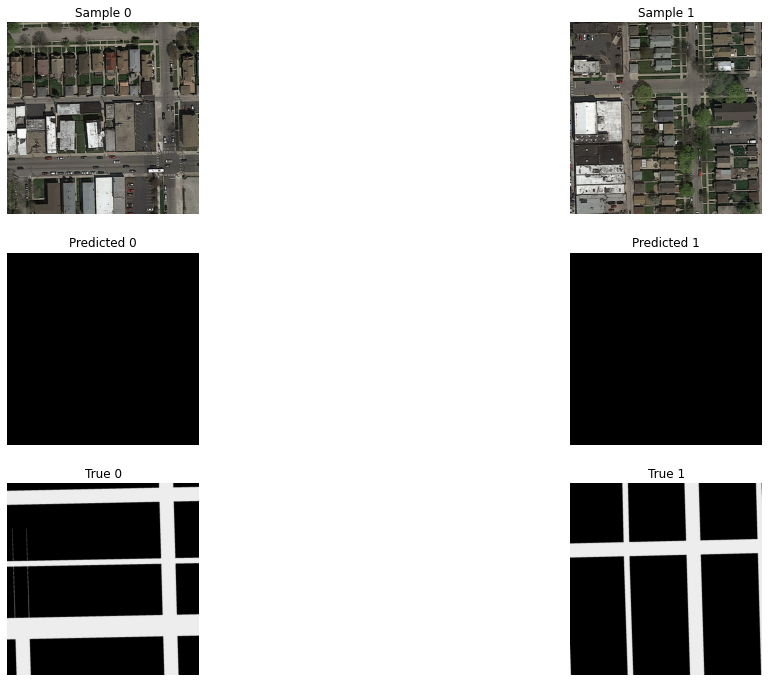


	- loss = 0.6301301767428716
  	- val_loss = 0.5530765354633331
  	- acc = 0.9385256320238113
  	- val_acc = 0.7811946272850037
 
tensor(1151, device='cuda:0') tensor(27710.2285, device='cuda:0')


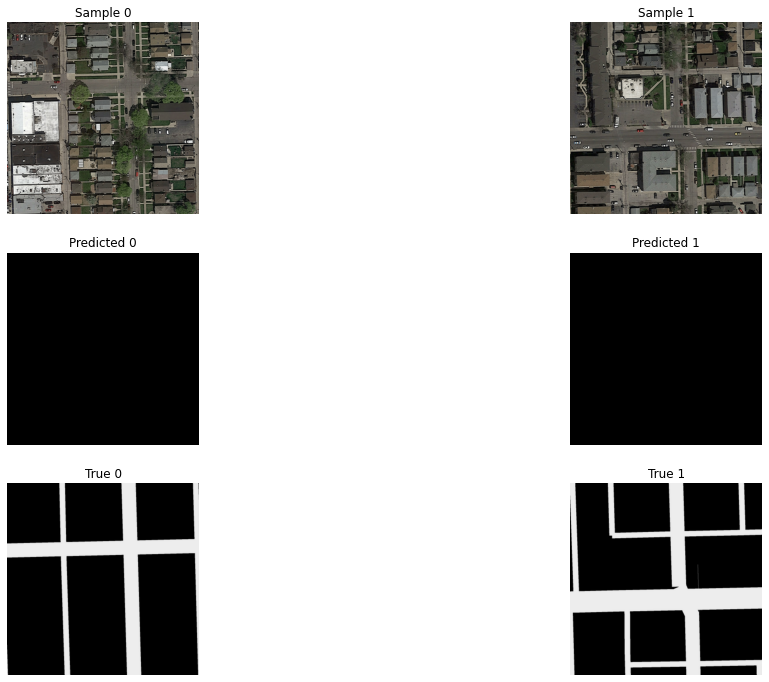


	- loss = 0.6285449663798014
  	- val_loss = 0.6088999509811401
  	- acc = 0.9433981478214264
  	- val_acc = 0.7813718616962433
 
tensor(3156, device='cuda:0') tensor(35444.9219, device='cuda:0')


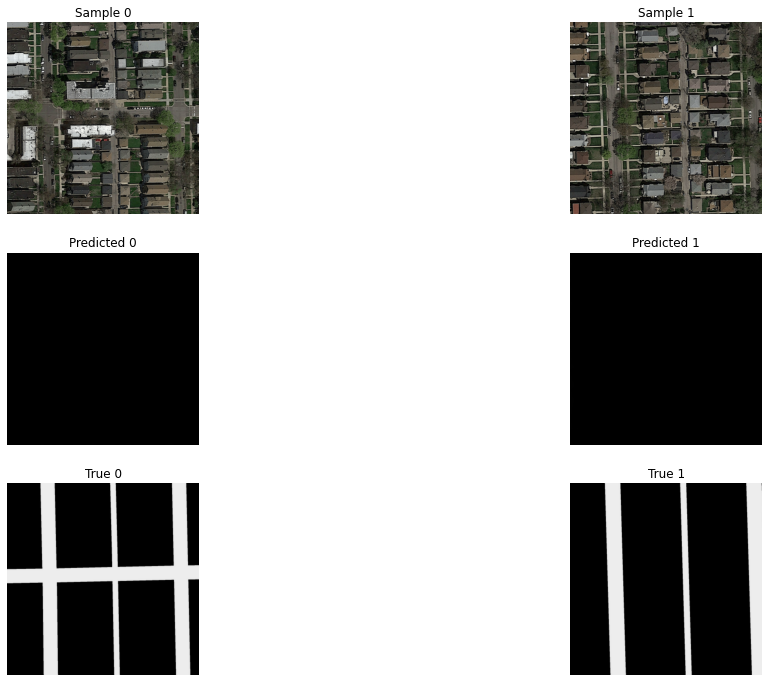


	- loss = 0.5863863428433737
  	- val_loss = 0.585259348154068
  	- acc = 0.954402968287468
  	- val_acc = 0.7928763329982758
 
tensor(3164, device='cuda:0') tensor(35444.9219, device='cuda:0')


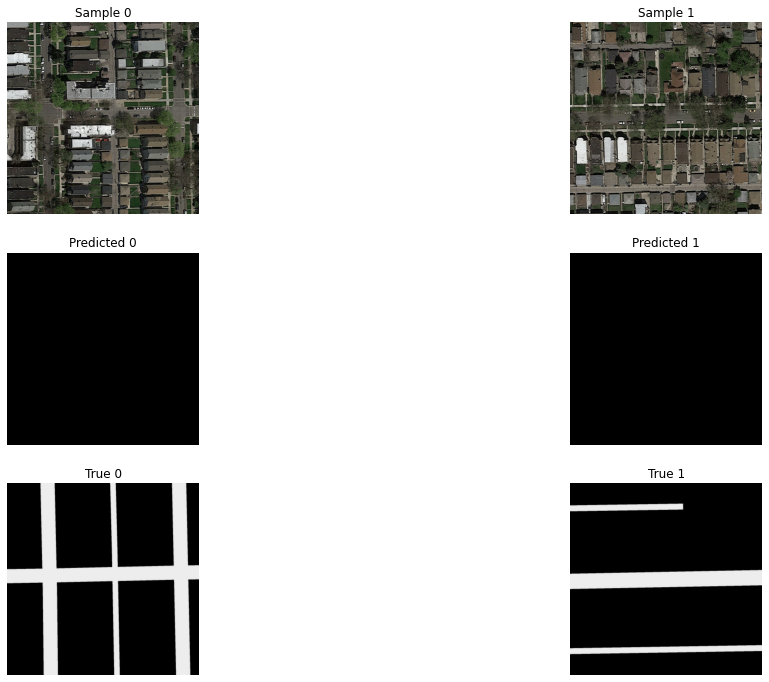


	- loss = 0.6028631826241811
  	- val_loss = 0.5710345506668091
  	- acc = 0.9593062202135721
  	- val_acc = 0.774181604385376
 
tensor(971, device='cuda:0') tensor(35274.7852, device='cuda:0')


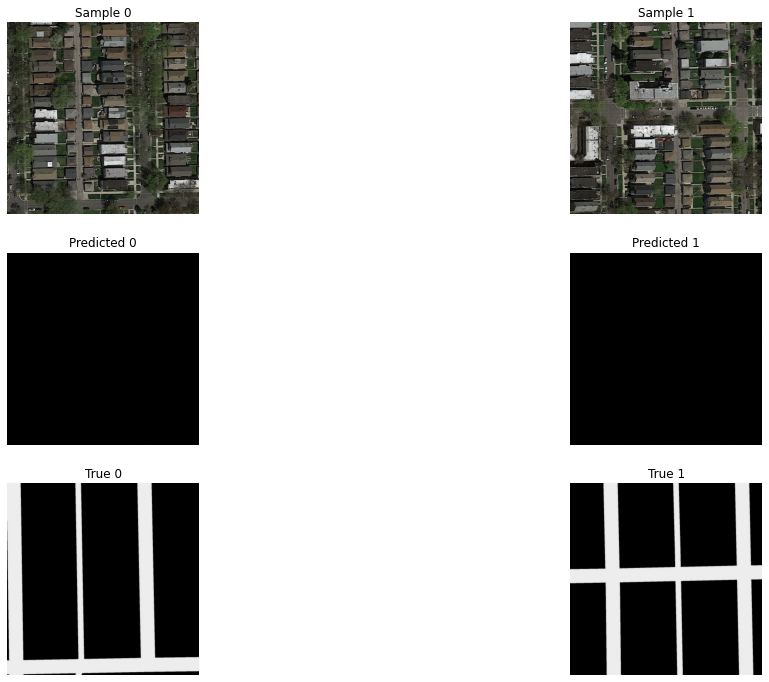


	- loss = 0.6282464762528738
  	- val_loss = 0.5594272315502167
  	- acc = 0.9326977531115214
  	- val_acc = 0.7640722393989563
 
tensor(1576, device='cuda:0') tensor(42676.2109, device='cuda:0')


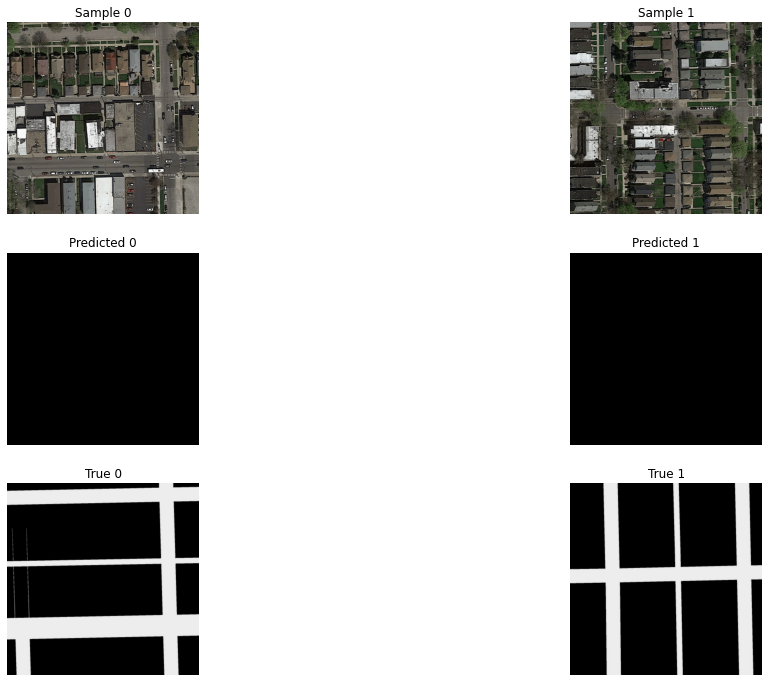


	- loss = 0.5929041653871536
  	- val_loss = 0.5861440896987915
  	- acc = 0.9524735411008199
  	- val_acc = 0.7937401235103607
 
tensor(3139, device='cuda:0') tensor(16694.8789, device='cuda:0')


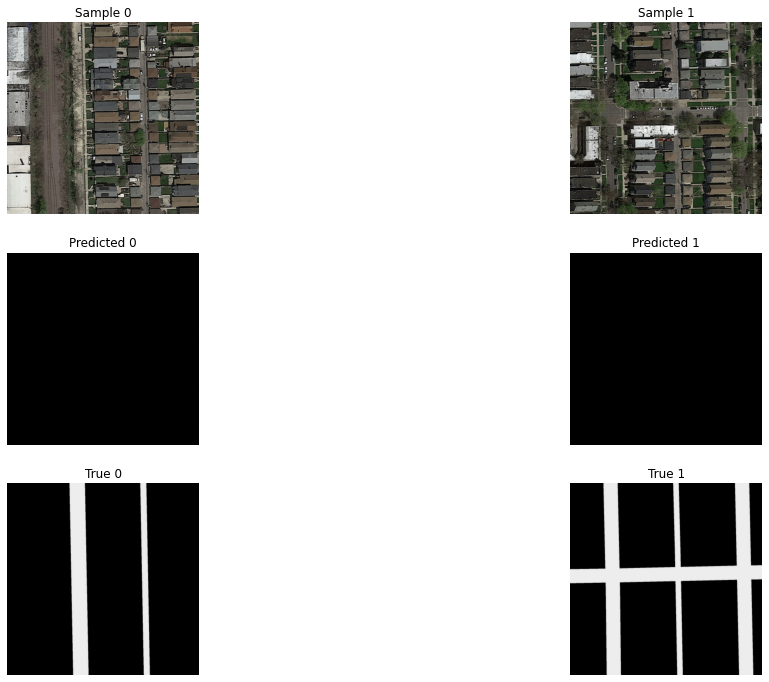


	- loss = 0.6011178145805994
  	- val_loss = 0.513081282377243
  	- acc = 0.9465070019165674
  	- val_acc = 0.7902317047119141
 
tensor(1688, device='cuda:0') tensor(16694.8789, device='cuda:0')


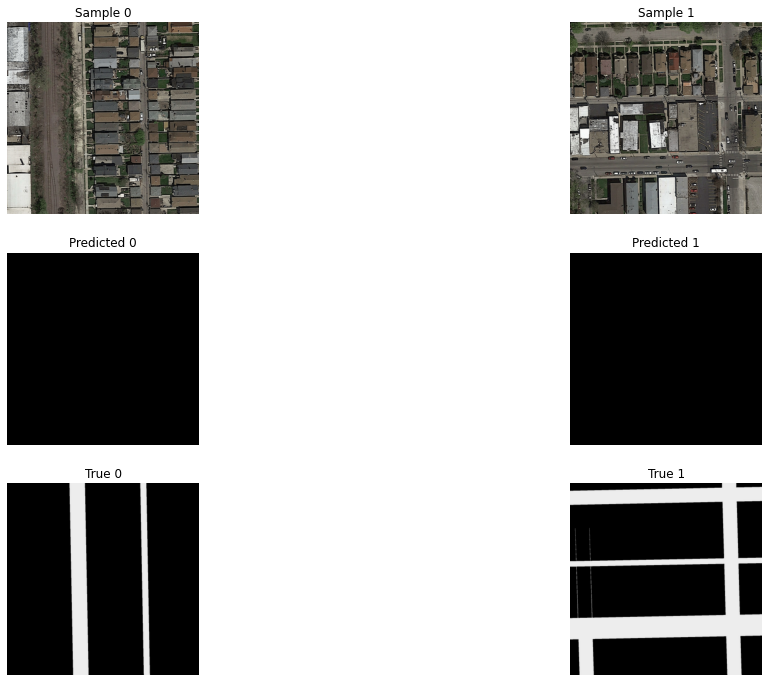


	- loss = 0.5651690065860748
  	- val_loss = 0.5251487493515015
  	- acc = 0.9656837036212286
  	- val_acc = 0.7768310308456421
 
tensor(1073, device='cuda:0') tensor(42676.2109, device='cuda:0')


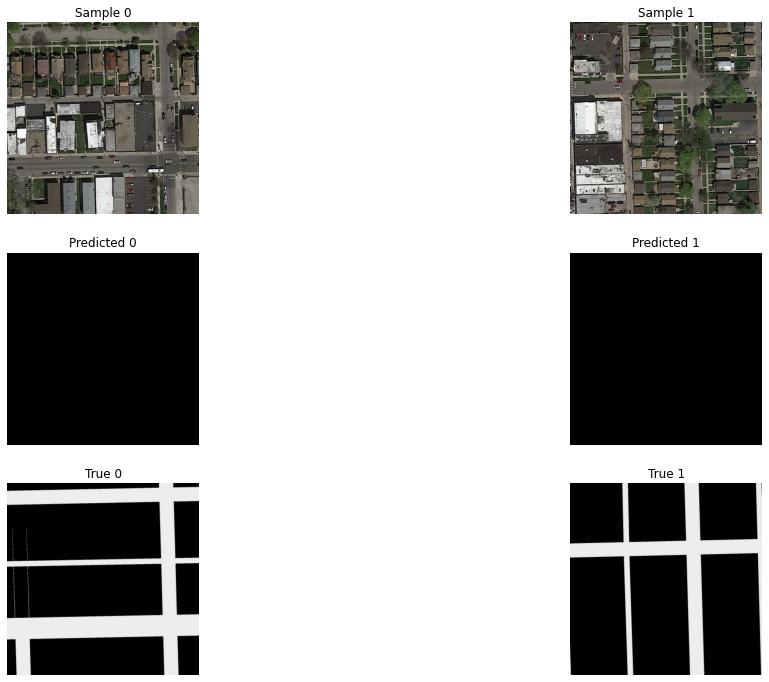


	- loss = 0.5860434919595718
  	- val_loss = 0.5295009613037109
  	- acc = 0.9630609105030695
  	- val_acc = 0.8086996078491211
 
tensor(1692, device='cuda:0') tensor(27921.2031, device='cuda:0')


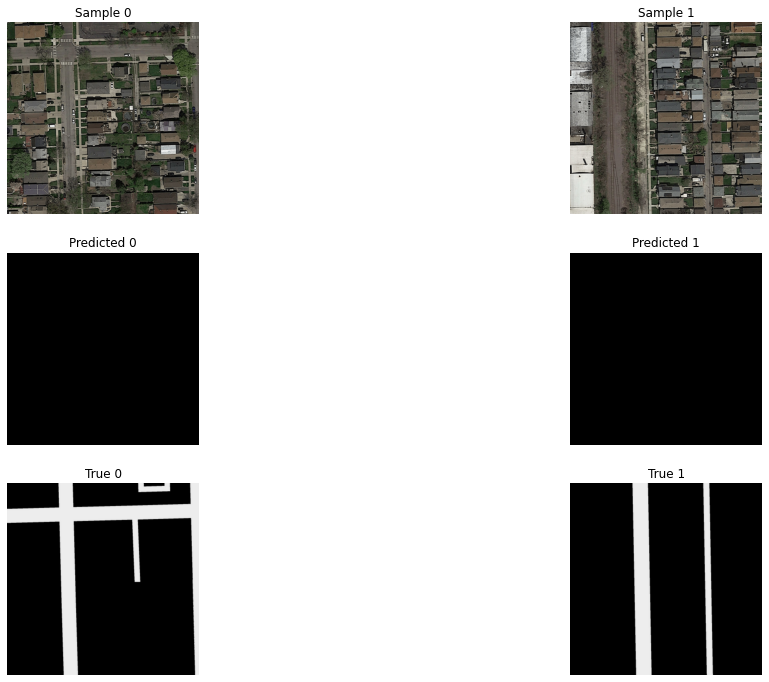


	- loss = 0.5695381760597229
  	- val_loss = 0.5004981905221939
  	- acc = 0.9645844797293345
  	- val_acc = 0.7827485203742981
 
tensor(460, device='cuda:0') tensor(27710.2285, device='cuda:0')


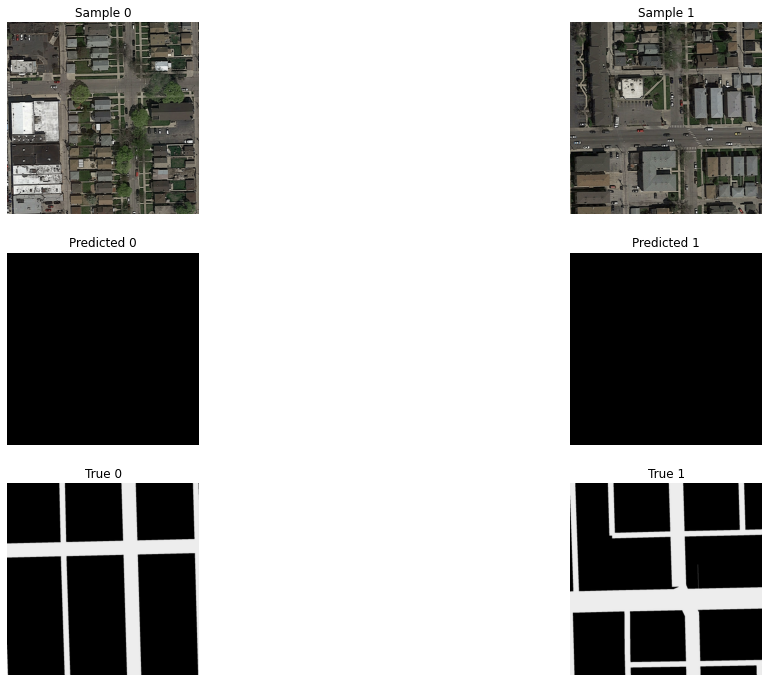


	- loss = 0.5539623995622
  	- val_loss = 0.5161658823490143
  	- acc = 0.9686648299296697
  	- val_acc = 0.777007669210434
 
tensor(1116, device='cuda:0') tensor(42676.2109, device='cuda:0')


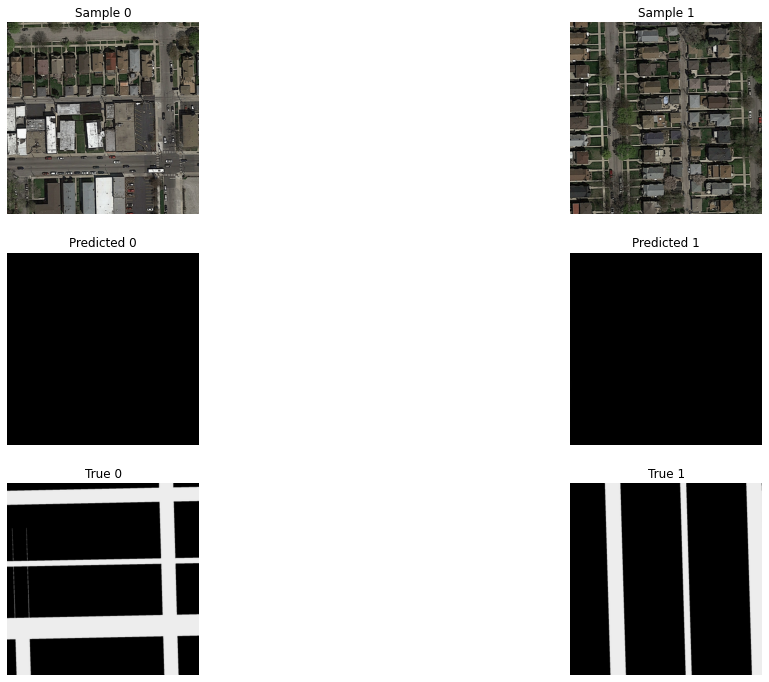


	- loss = 0.5270991250872612
  	- val_loss = 0.5189697742462158
  	- acc = 0.9758506218592325
  	- val_acc = 0.7867640256881714
 
tensor(366, device='cuda:0') tensor(27710.2285, device='cuda:0')


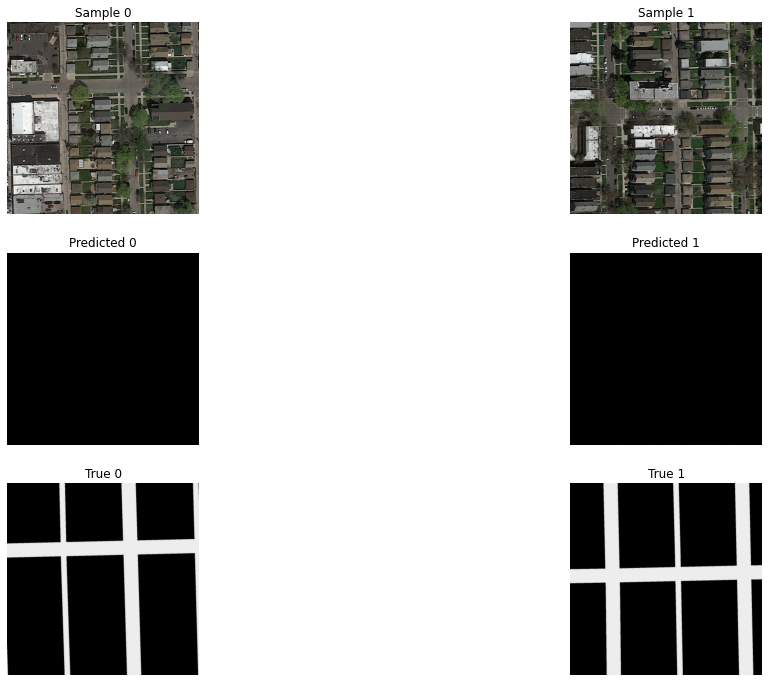

Finished Training


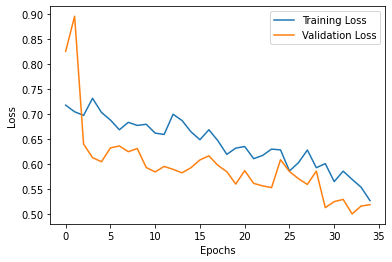

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# reshape the image to simplify the handling of skip connections and maxpooling
# train_dataset = ImageDataset('/content/drive/MyDrive/cil/training/additional_images', device, use_patches=False, resize_to=(400, 400))
# val_dataset = ImageDataset('/content/drive/MyDrive/cil/validation', device, use_patches=False, resize_to=(400, 400))

train_dataset = ImageDataset('/content/drive/MyDrive/cil/training', device, use_patches=False, resize_to=(400, 400))
val_dataset = ImageDataset('/content/drive/MyDrive/cil/validation', device, use_patches=False, resize_to=(400, 400))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)
model = PSPNet(layers=101, bins=(1, 2, 3, 6), dropout=0.5, classes=2, zoom_factor=1, use_ppm=True, pretrained=True, train = True).to(device)
#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()
metric_fns = {'acc': accuracy_fn}
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
n_epochs = 35
train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs)

In [ ]:
train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs)

In [ ]:
# predict on test set
test_filenames = (glob(test_path + '/*.png'))
test_images = load_all_from_path(test_path)
batch_size = test_images.shape[0]
size = test_images.shape[1:3]
# we also need to resize the test images. This might not be the best ideas depending on their spatial resolution.
test_images = np.stack([cv2.resize(img, dsize=(384, 384)) for img in test_images], 0)
test_images = np_to_tensor(np.moveaxis(test_images, -1, 1), device)
test_pred = [model(t).detach().cpu().numpy() for t in test_images.unsqueeze(1)]
test_pred = np.concatenate(test_pred, 0)
test_pred= np.moveaxis(test_pred, 1, -1)  # CHW to HWC
test_pred = np.stack([cv2.resize(img, dsize=size) for img in test_pred], 0)  # resize to original shape
# now compute labels
test_pred = test_pred.reshape((-1, size[0] // PATCH_SIZE, PATCH_SIZE, size[0] // PATCH_SIZE, PATCH_SIZE))
test_pred = np.moveaxis(test_pred, 2, 3)
test_pred = np.round(np.mean(test_pred, (-1, -2)) > CUTOFF)
create_submission(test_pred, test_filenames, submission_filename='unet_submission.csv')

In [ ]:
m = nn.Softmax(dim=0)
input = torch.randn(2, 3)
output = m(input)
print(input)
print(output)